# Data Analysis

For our models, we are going to be analyzing layoff data alongside information
about both the US's foreign aid spending per year and US GDP data.

### Methodology:

Our hypothesis is that given data about a company in conjunction with it's recent stock performance, we can predict the likelihood of a layoff. We will be using a variety of models to test this hypothesis.

## Retrieve STOCK DATA

In [78]:
# for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[*********************100%%**********************]  1 of 1 completed


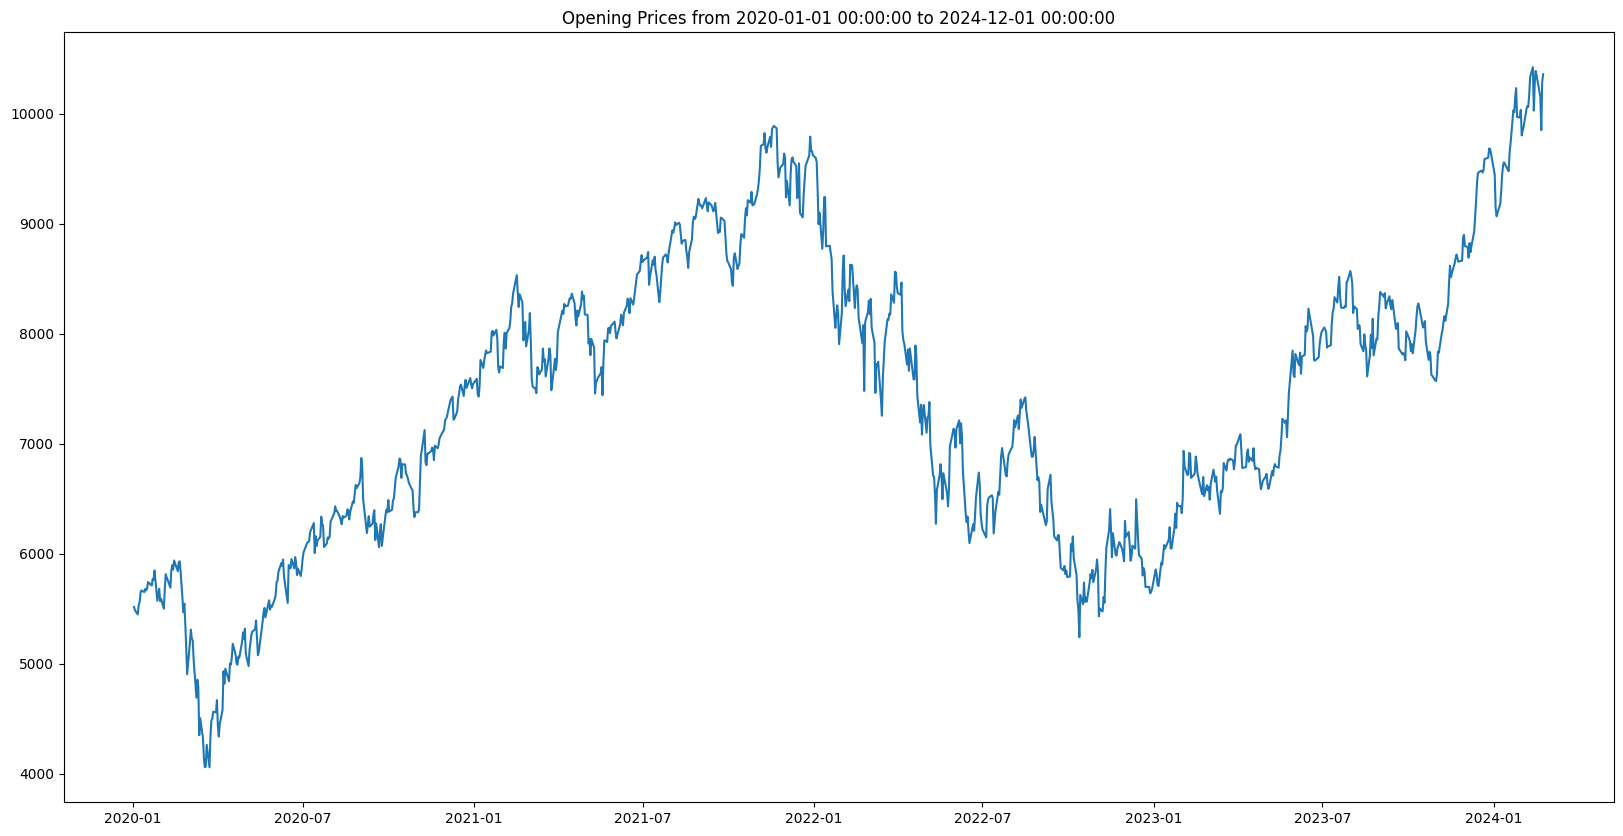

In [79]:
# TODO: weekly price diff (%) parsing from NDXT (NASDAQ 100 Tech companies index); add into data_pd as a new column

# for stock price retrieval
from datetime import datetime, timedelta
import yfinance as yf

# initialize parameters 
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 1)

# get the data 
stock_data = yf.download('^NDXT', start = start_date,
                         end = end_date)

stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8') # False: not include index

# display 
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(stock_data['Open'])
plt.show()

In [80]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [81]:
def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date

"""
@param stock_data: original stock_data df
@param week_end: layoff date
@param period: number of days to look back, defaults to 7

@return % of change in NDXT index price during last week before layoff date 
"""
def weekly_price_diff(stock_data, week_end, period: int = 7):
    # Check if week_end is a string and convert it to datetime object if necessary
    if isinstance(week_end, str):
        week_end = datetime.strptime(week_end, "%Y-%m-%d %H:%M:%S UTC")
    elif not isinstance(week_end, datetime):
        raise TypeError("week_end must be a datetime object or a string in '%Y-%m-%d %H:%M:%S UTC' format")
    
    if week_end < datetime(2020, 1, 15):
        return 0
    
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days=period))
    
    # Assuming stock_data is properly indexed by datetime
    price_end = stock_data.loc[date_end_closest, 'Open']
    price_start = stock_data.loc[date_start_closest, 'Open']
    price_diff = (price_end - price_start) / price_start * 100
    
    return price_diff  # in PERCENTAGE


price_diff = weekly_price_diff(stock_data, datetime(2022, 4, 11))
price_diff = round(price_diff, 2)
print(f"Diff between 11 APR 2022 and week before: {price_diff}%")

Diff between 11 APR 2022 and week before: -7.59%


In [82]:
# TODO: ADD RETRIEVED STOCK CHANGE TO DATA_PD

week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8')
stock_data

,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2020-01-02,5515.020020,5577.549805,5513.319824,5577.229980,5577.229980,284700,0
2020-01-03,5484.939941,5541.020020,5481.959961,5512.149902,5512.149902,260400,0
2020-01-06,5446.620117,5501.520020,5441.009766,5500.129883,5500.129883,241100,0
2020-01-07,5532.540039,5573.660156,5511.180176,5558.129883,5558.129883,297200,0
2020-01-08,5560.810059,5622.370117,5551.470215,5595.439941,5595.439941,279300,0
...,...,...,...,...,...,...,...
2024-02-16,10345.860352,10373.459961,10201.889648,10225.030273,10225.030273,0,0.12514
2024-02-20,10150.830078,10191.370117,9987.280273,10122.299805,10122.299805,0,1.231328
2024-02-21,9850.410156,9940.769531,9826.790039,9939.389648,9939.389648,0,-4.215232


In [83]:
def str_to_datetime(dt_string):
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")

layoff_data = pd.read_csv("tech_layoffs.csv")

layoff_data["Date_layoffs"] = layoff_data["Date_layoffs"].apply(lambda x: str_to_datetime(x))
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
Date_layoffs,,,,,,,,,,,,,,,
2020-03-12,3267,Tamara Mellon,Los Angeles,USA,North America,20,40.000000,50,30,Retail,Series C,$90,2020,34.05223,-118.24368
2020-03-13,3266,Panda Squad,San Francisco Bay Area,USA,North America,6,75.000000,8,2,Consumer,Seed,$1,2020,37.77493,-122.41942
2020-03-13,3265,HopSkipDrive,Los Angeles,USA,North America,8,10.000000,80,72,Transportation,Unknown,$45,2020,34.05223,-118.24368
2020-03-16,3262,Inspirato,Denver,USA,North America,130,22.000000,591,461,Travel,Series C,$79,2020,39.73915,-104.98470
2020-03-16,3263,Help.com,Austin,USA,North America,16,100.000000,16,0,Support,Seed,$6,2020,30.26715,-97.74306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,3279,Instagram,San Francisco Bay Area,USA,North America,60,13.333333,450,390,Consumer,Acquired,$57,2024,37.45383,-122.18219
2024-01-11,3272,Discord,San Francisco Bay Area,USA,North America,170,17.000000,1000,830,Consumer,Series H,$995,2024,37.77493,-122.41942
2024-01-11,3273,Inmobi,Bengaluru,India,Asia,125,5.000000,2500,2375,Marketing,Unknown,$320,2024,12.97194,77.59369


## ANALYZE DATA

In [84]:
import seaborn as sns

layoff_data = pd.read_csv("tech_layoffs.csv")
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,3286,Pitch,Berlin,Germany,Europe,80,2024-01-08 00:00:00 UTC,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,3287,BenchSci,Toronto,Canada,North America,70,2024-01-08 00:00:00 UTC,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-01-08 00:00:00 UTC,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-01-04 00:00:00 UTC,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [85]:
import pandas as pd  

print(layoff_data.head())

print(layoff_data.isnull().sum())

print(layoff_data.dtypes)

    #         Company             Location_HQ Country      Continent  \
0   3       ShareChat               Bengaluru   India           Asia   
1   4       InSightec                   Haifa  Israel           Asia   
2   6  Enphase Energy  San Francisco Bay Area     USA  North America   
3   7           Udaan               Bengaluru   India           Asia   
4  14          Cruise  San Francisco Bay Area     USA  North America   

   Laid_Off             Date_layoffs  Percentage  Company_Size_before_Layoffs  \
0       200  2023-12-20 00:00:00 UTC        15.0                         1333   
1       100  2023-12-19 00:00:00 UTC        20.0                          500   
2       350  2023-12-18 00:00:00 UTC        10.0                         3500   
3       100  2023-12-18 00:00:00 UTC        10.0                         1000   
4       900  2023-12-14 00:00:00 UTC        24.0                         3750   

   Company_Size_after_layoffs        Industry     Stage Money_Raised_in_$_mil  \

In [86]:
# Example: Renaming an incorrectly named company
layoff_data['Company'] = layoff_data['Company'].replace({'IncorrectName': 'CorrectName'})

# Handling missing values, if any
# For example, filling missing values with a placeholder or the median, depending on the context
layoff_data['Industry'].fillna('Placeholder', inplace=True)

In [87]:
# Filter for USA layoffs and group by year
layoffs_per_year_usa = layoff_data[layoff_data['Country'] == 'USA'].groupby('Year').size()
print("Number of Layoffs per Year in the USA:")
print(layoffs_per_year_usa)


Number of Layoffs per Year in the USA:
Year
2020    238
2021      9
2022    343
2023    303
2024     12
dtype: int64


In [88]:
# Identify top 3 industries affected based on layoffs count
top_industries_affected = layoff_data[layoff_data['Country'] == 'USA']['Industry'].value_counts().head(3)
print("\nTop Industries Affected in the USA:")
print(top_industries_affected)



Top Industries Affected in the USA:
Industry
Finance       114
Healthcare     74
Retail         59
Name: count, dtype: int64


In [89]:
# Top 10 geographical areas affected
top_areas_affected = layoff_data[layoff_data['Country'] == 'USA']['Location_HQ'].value_counts().head(10)
print("\nTop Geographical Areas Affected:")
print(top_areas_affected)

# Top 10 companies with the most layoffs
top_companies_layoffs = layoff_data['Company'].value_counts().head(10)
print("\nCompanies with Most Layoffs:")
print(top_companies_layoffs)


Top Geographical Areas Affected:
Location_HQ
San Francisco Bay Area    388
New York City             160
Boston                     60
Seattle                    51
Los Angeles                51
Chicago                    27
Austin                     17
Denver                     12
Salt Lake City             12
Washington DC               9
Name: count, dtype: int64

Companies with Most Layoffs:
Company
Uber                 5
Blend                5
Gopuff               5
Swiggy               5
Unity                5
Amazon               4
Pear Therapeutics    4
Redfin               4
Loft                 4
Beyond Meat          4
Name: count, dtype: int64


In [90]:
# Display general statistics about the dataset
general_stats = layoff_data.describe(include='all').round(2)
print("\nGeneral Statistics About the Dataset:")
print(general_stats)


General Statistics About the Dataset:
              # Company             Location_HQ Country      Continent  \
count   1418.00    1418                    1418    1418           1418   
unique      NaN    1128                     132      37              6   
top         NaN    Uber  San Francisco Bay Area     USA  North America   
freq        NaN       5                     388     905            986   
mean    1823.41     NaN                     NaN     NaN            NaN   
std      922.67     NaN                     NaN     NaN            NaN   
min        3.00     NaN                     NaN     NaN            NaN   
25%     1038.50     NaN                     NaN     NaN            NaN   
50%     1882.50     NaN                     NaN     NaN            NaN   
75%     2616.25     NaN                     NaN     NaN            NaN   
max     3290.00     NaN                     NaN     NaN            NaN   

        Laid_Off             Date_layoffs  Percentage  \
count    1418.0

In [91]:
# Example of dropping unnecessary columns
columns_to_drop = ['#', 'lat', 'lng']  # Adjust based on your analysis needs
layoff_data_cleaned = layoff_data.drop(columns=columns_to_drop)
print("\nDataset after dropping unnecessary columns:")
print(layoff_data_cleaned.columns.tolist())



Dataset after dropping unnecessary columns:
['Company', 'Location_HQ', 'Country', 'Continent', 'Laid_Off', 'Date_layoffs', 'Percentage', 'Company_Size_before_Layoffs', 'Company_Size_after_layoffs', 'Industry', 'Stage', 'Money_Raised_in_$_mil', 'Year']


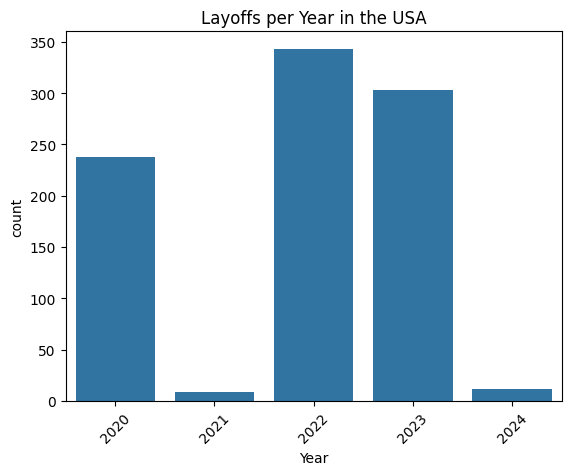

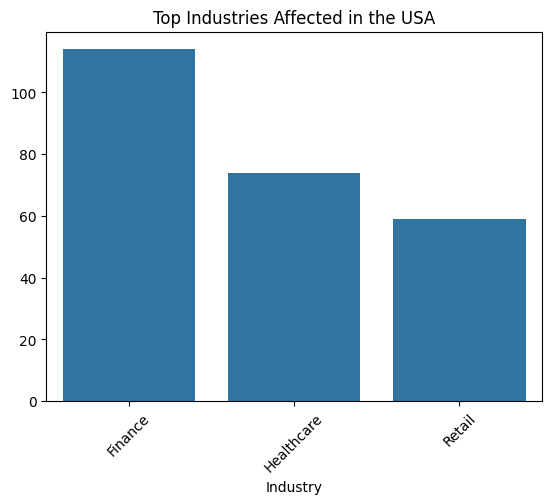

In [92]:
sns.countplot(data=layoff_data[layoff_data['Country'] == 'USA'], x='Year')
plt.xticks(rotation=45)
plt.title('Layoffs per Year in the USA')
plt.show()

# Correcting the reference for top industries affected and visualizing
sns.barplot(x=top_industries_affected.index, y=top_industries_affected.values)
plt.xticks(rotation=45)
plt.title('Top Industries Affected in the USA')
plt.show()

In [93]:
# TODO: NOW NEED TO ADD ACCORDING STOCK PRICE CHANGE TO LAYOFF_DATA
# layoff_data_with_date_col = layoff_data.reset_index()
layoff_data_with_stock = layoff_data.reset_index()

#Create a new column for stock price change, and add it to the layoff_data_with_date_col dataframe
layoff_data_with_stock.insert(1, "stock_delta", layoff_data_with_stock["Date_layoffs"].apply(lambda x: weekly_price_diff(stock_data, x, period=14)))
layoff_data_with_stock  # bug: several stock_delta values are 0, which is highly improbable.
# Possible reason: stock_data does not contain the dates surrounding the layoff

,index,stock_delta,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,0,7.259072,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,1,9.101187,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,2,7.893841,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,3,7.893841,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,4,5.332364,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,1413,-4.221007,3286,Pitch,Berlin,Germany,Europe,80,2024-01-08 00:00:00 UTC,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,1414,-4.221007,3287,BenchSci,Toronto,Canada,North America,70,2024-01-08 00:00:00 UTC,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,1415,-4.221007,3288,NanoString Technology,Seattle,USA,North America,50,2024-01-08 00:00:00 UTC,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,1416,-4.395846,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-01-04 00:00:00 UTC,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [94]:
print("The countries we are working with are: ", layoff_data['Country'].unique())
print("The number of observations in the layoffs dataset is: ", layoff_data.shape[0])
print("The number of features in the layoffs dataset is: ", layoff_data.shape[1])


The countries we are working with are:  ['India' 'Israel' 'USA' 'Sweden' 'United Kingdom' 'Canada' 'France'
 'Netherlands' 'Germany' 'Estonia' 'Kenya' 'Brazil' 'New Zealand'
 'Ireland' 'Australia' 'Singapore' 'Chile' 'Spain' 'South Korea'
 'Indonesia' 'Japan' 'China' 'Argentina' 'Nigeria'
 'United Arabian Emirates' 'Denmark' 'Norway' 'Thailand' 'Senegal'
 'Hong Kong' 'Austria' 'Finland' 'Malaysia' 'Mexico' 'Russia'
 'Switzerland' 'Portugal']
The number of observations in the layoffs dataset is:  1418
The number of features in the layoffs dataset is:  16


In [95]:
print("The number of observations in the stock dataset is: ", stock_data.shape[0])
print("The number of features in the stock dataset is: ", stock_data.shape[1])

The number of observations in the stock dataset is:  1043
The number of features in the stock dataset is:  7


In [96]:
print(layoff_data.dtypes)

#                                int64
Company                         object
Location_HQ                     object
Country                         object
Continent                       object
Laid_Off                         int64
Date_layoffs                    object
Percentage                     float64
Company_Size_before_Layoffs      int64
Company_Size_after_layoffs       int64
Industry                        object
Stage                           object
Money_Raised_in_$_mil           object
Year                             int64
lat                            float64
lng                            float64
dtype: object


In [97]:
layoff_data.isna().sum()

#                              0
Company                        0
Location_HQ                    0
Country                        0
Continent                      0
Laid_Off                       0
Date_layoffs                   0
Percentage                     0
Company_Size_before_Layoffs    0
Company_Size_after_layoffs     0
Industry                       0
Stage                          0
Money_Raised_in_$_mil          0
Year                           0
lat                            0
lng                            0
dtype: int64

In [98]:
layoff_data.describe().round(2)

,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00
mean,1823.41,267.39,21.90,3556.23,3288.84,2021.88,33.79,-59.65
std,922.67,877.47,20.66,22478.37,21878.26,1.15,18.81,74.47
min,3.00,3.00,0.04,4.00,0.00,2020.00,-41.29,-123.12
25%,1038.50,40.00,10.00,213.00,151.25,2022.00,34.05,-122.27
50%,1882.50,86.00,15.00,531.00,430.00,2022.00,37.77,-79.40
75%,2616.25,200.00,27.00,1414.75,1200.00,2023.00,42.33,-0.13
max,3290.00,12000.00,100.00,400000.00,392000.00,2024.00,60.17,174.78


In [99]:
# Extract percentage targets
layoff_target = layoff_data['Percentage']
layoff_target

0        15.0
1        20.0
2        10.0
3        10.0
4        24.0
        ...  
1413     67.0
1414     17.0
1415      9.0
1416     15.0
1417    100.0
Name: Percentage, Length: 1418, dtype: float64

In [100]:
# Drop target from remaining features
layoff_data_with_stock = layoff_data_with_stock.drop('Percentage', axis=1)
layoff_data_with_stock

,index,stock_delta,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,0,7.259072,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,1,9.101187,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,2,7.893841,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,3,7.893841,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,4,5.332364,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,1413,-4.221007,3286,Pitch,Berlin,Germany,Europe,80,2024-01-08 00:00:00 UTC,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,1414,-4.221007,3287,BenchSci,Toronto,Canada,North America,70,2024-01-08 00:00:00 UTC,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,1415,-4.221007,3288,NanoString Technology,Seattle,USA,North America,50,2024-01-08 00:00:00 UTC,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,1416,-4.395846,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-01-04 00:00:00 UTC,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [101]:
# Describe features
layoff_data_with_stock.describe().round(2)

,index,stock_delta,#,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00
mean,708.50,1.71,1823.41,267.39,3556.23,3288.84,2021.88,33.79,-59.65
std,409.49,6.07,922.67,877.47,22478.37,21878.26,1.15,18.81,74.47
min,0.00,-22.37,3.00,3.00,4.00,0.00,2020.00,-41.29,-123.12
25%,354.25,-2.11,1038.50,40.00,213.00,151.25,2022.00,34.05,-122.27
50%,708.50,2.36,1882.50,86.00,531.00,430.00,2022.00,37.77,-79.40
75%,1062.75,5.97,2616.25,200.00,1414.75,1200.00,2023.00,42.33,-0.13
max,1417.00,18.05,3290.00,12000.00,400000.00,392000.00,2024.00,60.17,174.78


<Axes: xlabel='Percentage', ylabel='Count'>

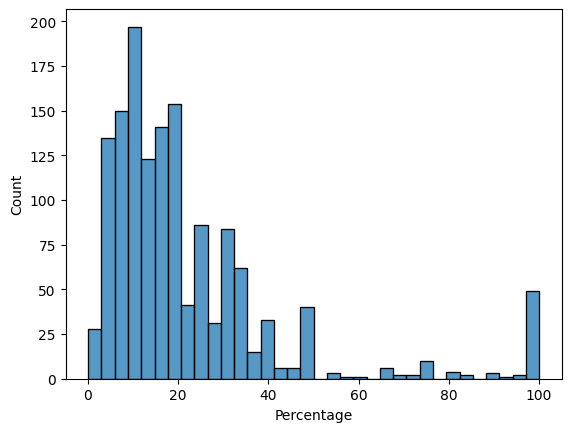

In [102]:
# Plot histogram of layoff percentages
sns.histplot(layoff_target)

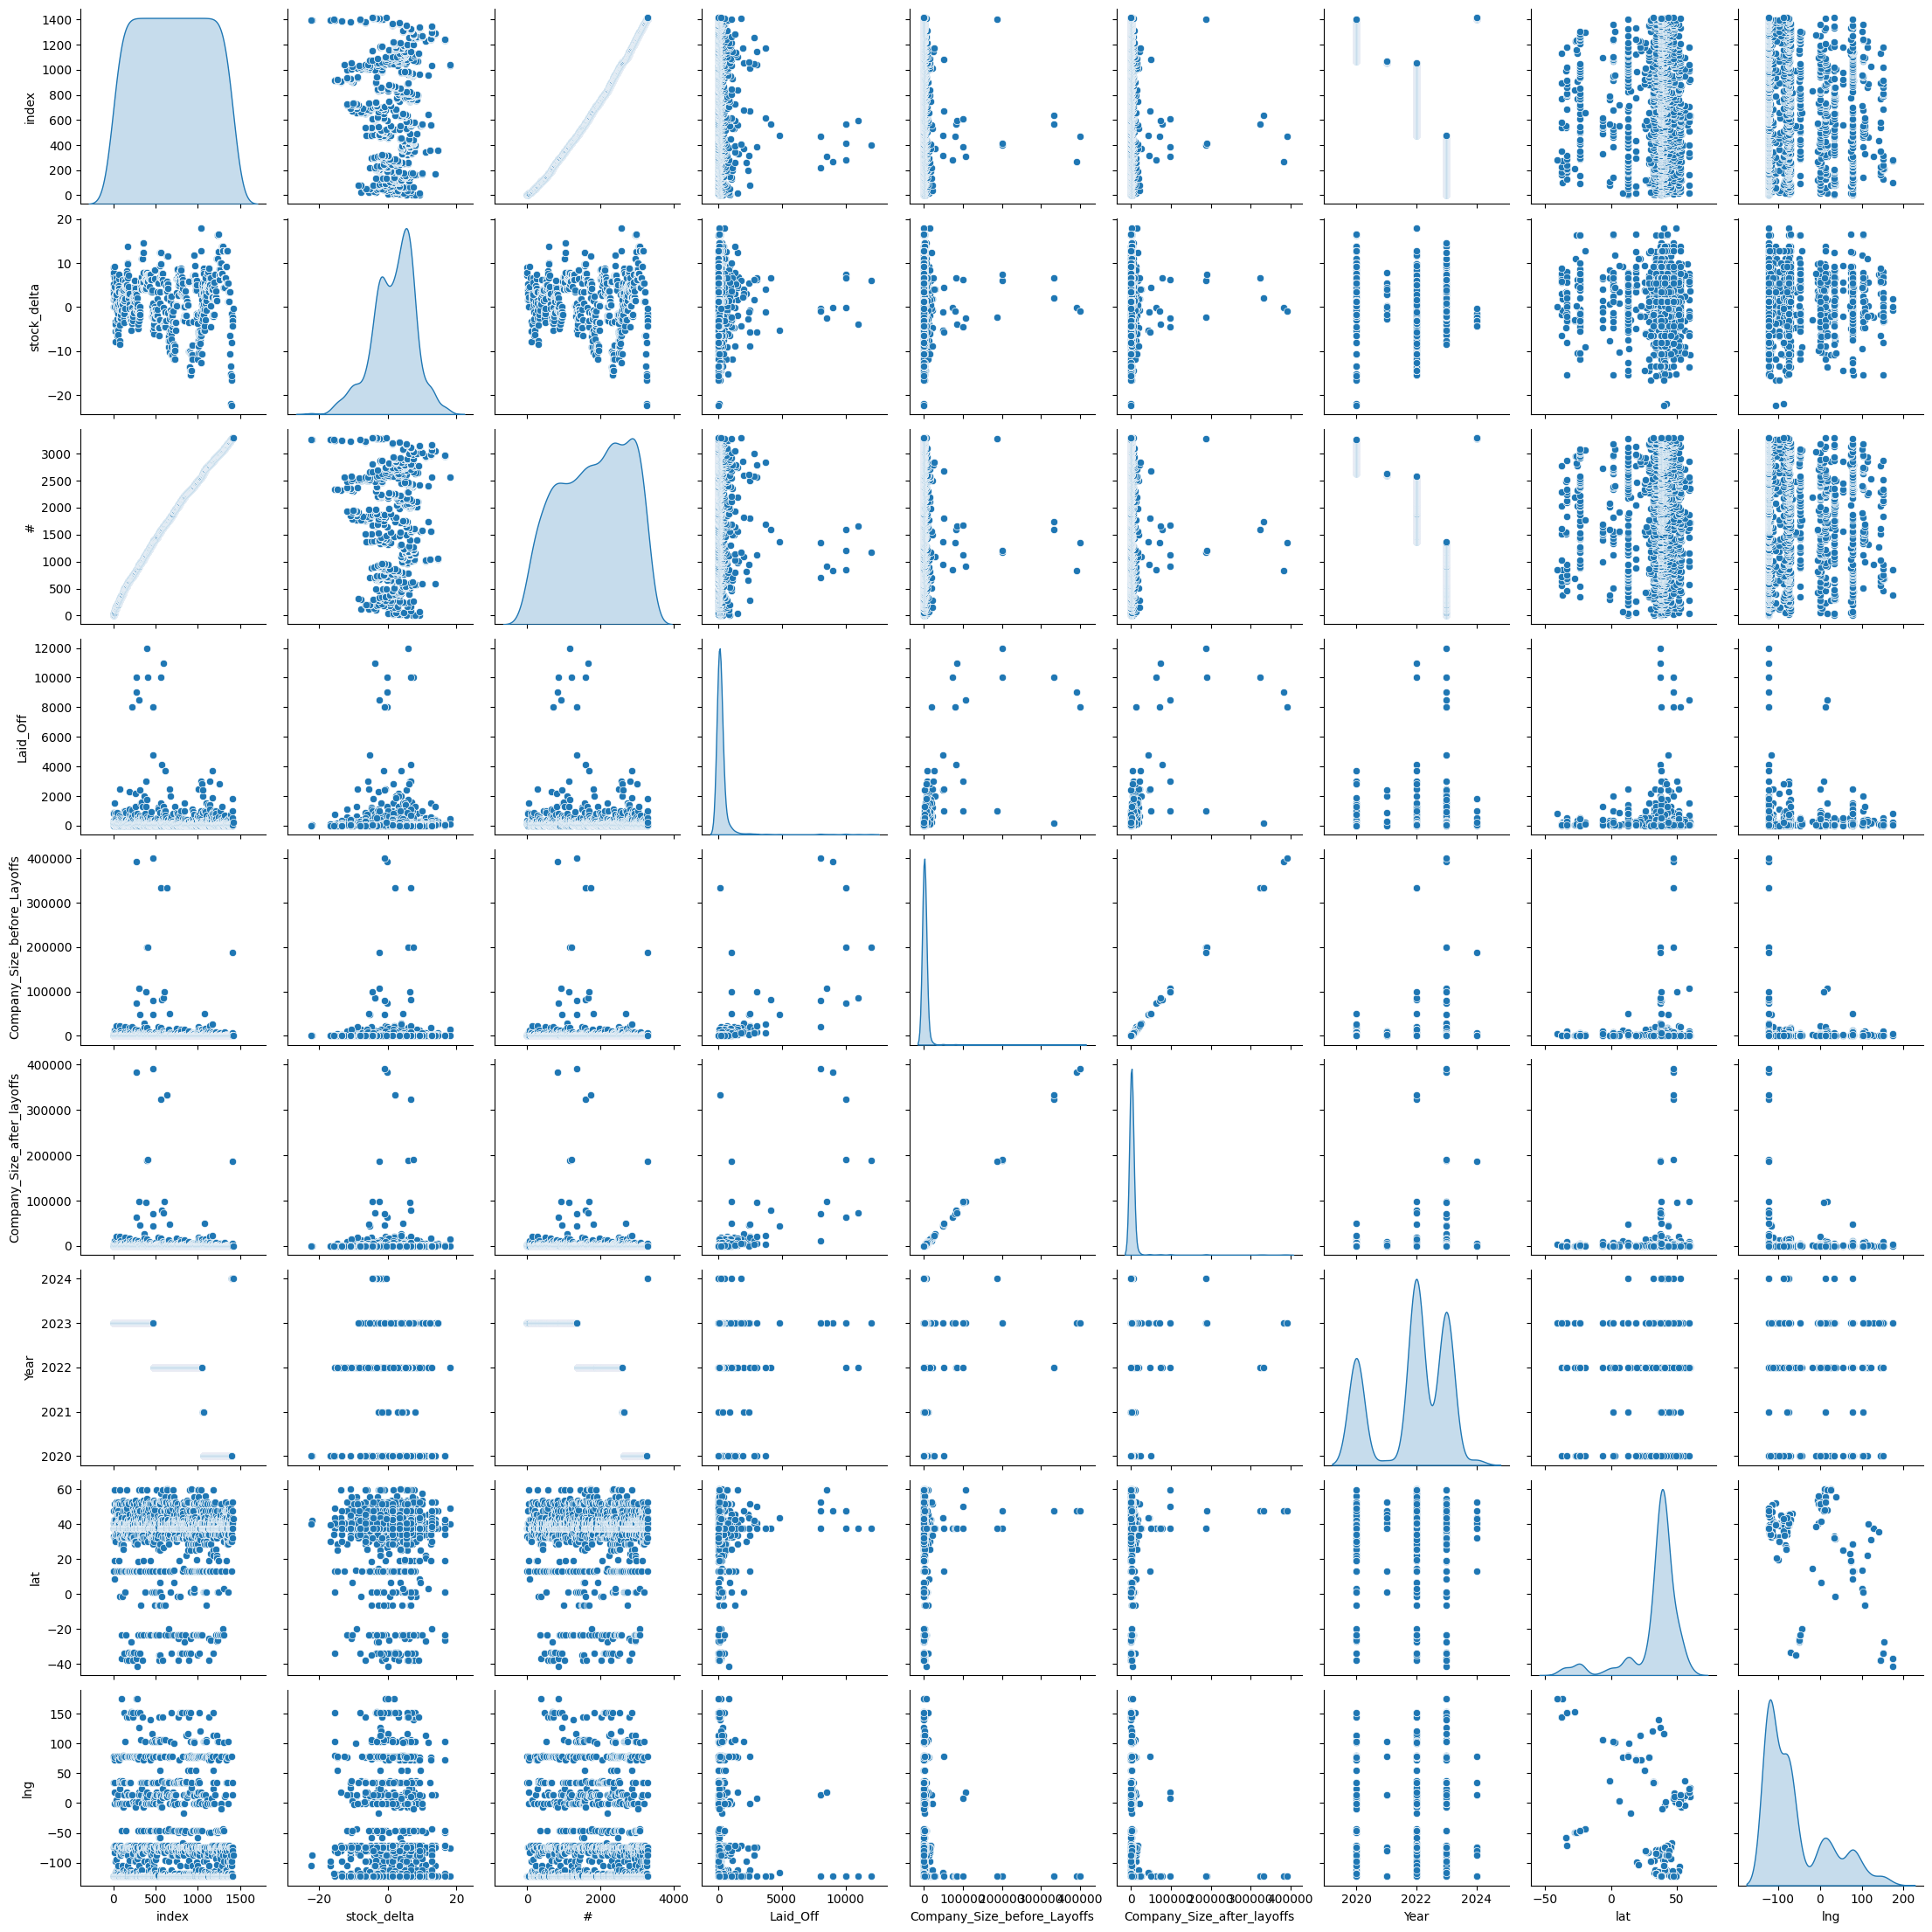

In [103]:
# Create pairplot of features
sns.pairplot(layoff_data_with_stock, diag_kind='kde')

In [104]:
# For American companies, let's see some insights related to total layoff counts and tech layoffs by industry.

In [105]:
# Drop qualitative columns
dropped_cols = [
    'Company',
    'Location_HQ',
    'Country',
    'Continent',
    'Industry',
    'Stage',
]

corr_df = layoff_data_with_stock.drop(columns=dropped_cols)

In [106]:
# Convert money to float for correlations
corr_df['Money_Raised_in_$_mil'] = corr_df['Money_Raised_in_$_mil'].replace(to_replace='[\$]', value='', regex=True).astype(float)
corr_df

,index,stock_delta,#,Laid_Off,Date_layoffs,Company_Size_before_Layoffs,Company_Size_after_layoffs,Money_Raised_in_$_mil,Year,lat,lng
0,0,7.259072,3,200,2023-12-20 00:00:00 UTC,1333,1133,1700.0,2023,12.97194,77.59369
1,1,9.101187,4,100,2023-12-19 00:00:00 UTC,500,400,733.0,2023,32.81841,34.98850
2,2,7.893841,6,350,2023-12-18 00:00:00 UTC,3500,3150,116.0,2023,37.54827,-121.98857
3,3,7.893841,7,100,2023-12-18 00:00:00 UTC,1000,900,1500.0,2023,12.97194,77.59369
4,4,5.332364,14,900,2023-12-14 00:00:00 UTC,3750,2850,15000.0,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...
1413,1413,-4.221007,3286,80,2024-01-08 00:00:00 UTC,119,39,138.0,2024,52.52437,13.41053
1414,1414,-4.221007,3287,70,2024-01-08 00:00:00 UTC,412,342,164.0,2024,43.70643,-79.39864
1415,1415,-4.221007,3288,50,2024-01-08 00:00:00 UTC,556,506,826.0,2024,47.60621,-122.33207
1416,1416,-4.395846,3289,30,2024-01-04 00:00:00 UTC,200,170,199.0,2024,32.08088,34.78057


In [107]:
# Create correlation
corr = corr_df.corr()
corr

ValueError: could not convert string to float: '2023-12-20 00:00:00 UTC'

<Axes: >

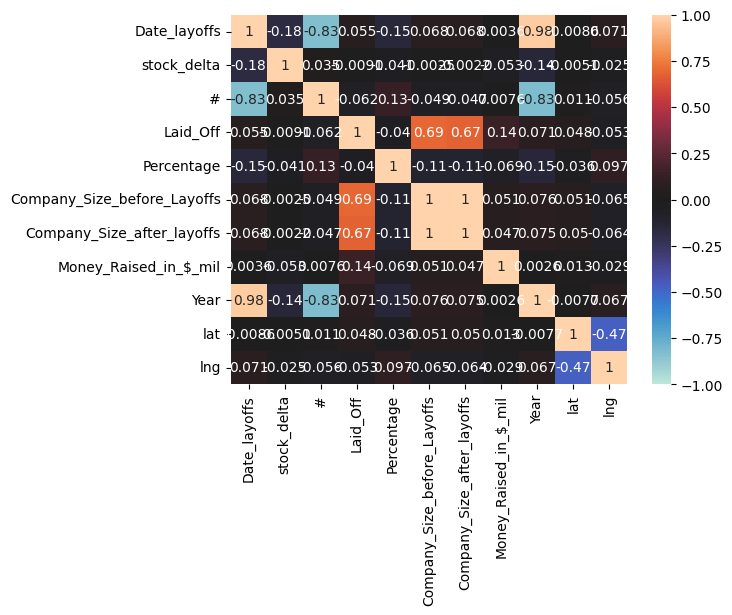

In [ ]:
# Plot correlation onto heatmap
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True)

In [ ]:
# NOTE: May want to check correlation between layoff percentage and features

In [ ]:
gdp_data = pd.read_csv('country-gdps.csv')
gdp_data

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.727850e+09,2.790850e+09,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.558906e+09,3.103184e+09,3.544708e+09
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1.847810e+10,1.936631e+10,2.050647e+10,2.224273e+10,2.429433e+10,2.661956e+10,...,9.863429e+11,1.006992e+12,9.325135e+11,8.900514e+11,1.028394e+12,1.012521e+12,1.006191e+12,9.288802e+11,1.086531e+12,1.185138e+12
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.014642e+10,2.049713e+10,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426650e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.041165e+10,1.113592e+10,1.195171e+10,1.268581e+10,1.384900e+10,1.487476e+10,...,8.340970e+11,8.945050e+11,7.692632e+11,6.921149e+11,6.856303e+11,7.681582e+11,8.234056e+11,7.869624e+11,8.449275e+11,8.753937e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.323391e+11,1.359668e+11,9.049642e+10,5.276162e+10,7.369016e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.067828e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.735329e+09,7.074395e+09,6.295848e+09,6.682677e+09,7.180765e+09,7.878760e+09,7.899738e+09,7.717145e+09,9.412034e+09,9.409474e+09
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.041523e+10,4.322859e+10,4.244449e+10,3.131782e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,8.748597e+09,9.225996e+09,9.813996e+09,1.085420e+10,1.195600e+10,1.306899e+10,...,4.008860e+11,3.811989e+11,3.467098e+11,3.235855e+11,3.814488e+11,4.052607e+11,3.893300e+11,3.382914e+11,4.201178e+11,4.052709e+11
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631151e+10,2.330867e+10,1.811064e+10,2.209642e+10,2.916378e+10


In [ ]:
gdp_data.isna().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2018                8
2019                8
2020                9
2021               10
2022               23
Length: 67, dtype: int64

In [ ]:
gdp_data.describe().round(2)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.260000e+02,1.270000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.400000e+02,1.430000e+02,1.460000e+02,1.510000e+02,1.510000e+02,...,2.590000e+02,2.600000e+02,2.580000e+02,2.580000e+02,2.580000e+02,2.580000e+02,2.580000e+02,2.570000e+02,2.560000e+02,2.430000e+02
mean,7.295339e+10,7.486095e+10,7.866324e+10,8.518005e+10,9.404305e+10,9.429468e+10,1.044708e+11,1.087439e+11,1.136923e+11,1.255383e+11,...,2.482324e+12,2.543694e+12,2.404723e+12,2.437760e+12,2.613243e+12,2.776038e+12,2.817910e+12,2.741618e+12,3.169838e+12,3.479221e+12
std,2.186744e+11,2.282797e+11,2.438626e+11,2.628174e+11,2.877300e+11,3.004628e+11,3.282242e+11,3.474790e+11,3.696235e+11,4.066424e+11,...,8.401587e+12,8.612905e+12,8.172390e+12,8.309604e+12,8.845331e+12,9.414852e+12,9.553275e+12,9.323528e+12,1.068868e+13,1.133619e+13
min,1.201202e+07,1.159202e+07,9.122751e+06,1.084010e+07,1.271247e+07,1.359393e+07,1.446908e+07,1.583511e+07,1.460000e+07,1.585000e+07,...,3.861589e+07,3.876098e+07,3.681194e+07,4.162906e+07,4.527660e+07,4.801526e+07,5.412320e+07,5.174659e+07,6.019641e+07,5.906598e+07
25%,5.151683e+08,5.111424e+08,5.185977e+08,5.150864e+08,5.415796e+08,5.199337e+08,5.894217e+08,5.190310e+08,5.605380e+08,5.988611e+08,...,8.486163e+09,9.034786e+09,8.752203e+09,8.620984e+09,9.319389e+09,1.002804e+10,1.035516e+10,9.754600e+09,1.080873e+10,1.403573e+10
50%,2.661058e+09,2.417629e+09,2.319980e+09,2.680117e+09,2.853831e+09,2.913602e+09,3.039859e+09,3.145743e+09,3.330372e+09,3.787077e+09,...,5.094967e+10,5.339986e+10,4.966767e+10,4.984325e+10,5.400009e+10,5.609719e+10,6.009099e+10,5.373453e+10,6.561177e+10,7.573231e+10
75%,2.398013e+10,2.365180e+10,2.289222e+10,2.428285e+10,2.625211e+10,2.509067e+10,2.793416e+10,2.899389e+10,3.209482e+10,3.636104e+10,...,5.390198e+11,5.478563e+11,5.020845e+11,5.057567e+11,5.369244e+11,5.524163e+11,5.419490e+11,5.470542e+11,6.501228e+11,8.912561e+11
max,1.381135e+12,1.446356e+12,1.546369e+12,1.670666e+12,1.832616e+12,1.994519e+12,2.161645e+12,2.308597e+12,2.491805e+12,2.745216e+12,...,7.771472e+13,7.983716e+13,7.528327e+13,7.651898e+13,8.148410e+13,8.654268e+13,8.777740e+13,8.525774e+13,9.752968e+13,1.013257e+14


In [ ]:
foreign_aid_data = pd.read_csv('us-foreign-aid.csv')
foreign_aid_data

,Country Code,Country Name,Region ID,Region Name,Income Group Acronym,Income Group Name,Transaction Type ID,Transaction Type Name,Fiscal Year,current_amount,constant_amount
0,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,1999,19000,31338
1,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2000,50000,80787
2,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2004,1000,1487
3,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2005,29270,42255
4,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2006,1000,1398
...,...,...,...,...,...,...,...,...,...,...,...
21549,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2019,286696401,321092817
21550,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2020,276466581,305559343
21551,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2021,314260262,336034603
21552,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2022,344133221,344133221


In [ ]:
foreign_aid_data.isna().sum()

Country Code               55
Country Name                0
Region ID                   0
Region Name                 0
Income Group Acronym     2384
Income Group Name        2384
Transaction Type ID         0
Transaction Type Name       0
Fiscal Year                 0
current_amount              0
constant_amount             0
dtype: int64

In [ ]:
foreign_aid_data.describe().round(2)

,Region ID,Transaction Type ID,current_amount,constant_amount
count,21554.00,21554.00,2.155400e+04,2.155400e+04
mean,3.85,4.02,1.768907e+08,2.835380e+08
std,1.82,5.18,9.854787e+08,1.321976e+09
min,1.00,1.00,-6.382327e+07,-4.976816e+08
25%,2.00,2.00,1.700000e+06,3.102825e+06
50%,5.00,2.00,1.759600e+07,3.056596e+07
75%,5.00,3.00,7.916878e+07,1.291599e+08
max,7.00,18.00,2.594584e+10,4.085656e+10


## TO DO:
Add what steps we will take to preprocess data (i.e. scaling, normalization, etc.) and why we chose these steps. 
Also maybe add what models we want to use.
